




### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.


### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.












# Goal: 
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

In [2]:

import pandas as pd
import numpy as np 

import scipy.stats as st
from simple_colors import *
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import lines
from matplotlib import patches
from matplotlib.patheffects import withStroke

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import tensorflow as tf 
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pandas_profiling
from scipy.stats import chi2_contingency 
sns.set_context("talk")

In [3]:
contract = pd.read_csv('contract.csv',)
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')

In [4]:
# Using an outer join to merge all csv files on customerID 
data = contract.merge(internet, on = 'customerID', how = 'outer').merge(personal, on = 'customerID', how= 'outer').merge(phone, on = 'customerID', how= 'outer')

In [5]:
# lowercasing all the columns 
data.columns = data.columns.str.lower()

In [6]:
data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [7]:
# checking shape of the data
print("There are", data.shape[0], 'rows and', data.shape[1], "columns.")

There are 7043 rows and 20 columns.


In [8]:
# Getting an overview of information from the Dataframe 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
 8   internetservice   5517 non-null   object 
 9   onlinesecurity    5517 non-null   object 
 10  onlinebackup      5517 non-null   object 
 11  deviceprotection  5517 non-null   object 
 12  techsupport       5517 non-null   object 
 13  streamingtv       5517 non-null   object 
 14  streamingmovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  seniorcitizen     7043 non-null   int64  


- There are a total of 18 object type columns, one float and one int type
- We have some issues in begindate and enddate columns they being read as object type 
- total charges as well is being read as object type will change to float 


In [9]:
print(f' Unique values for "begindata column:\n {data.begindate.unique()} \n Unique Dates for enddata column: \n { data.enddate.unique()}')

 Unique values for "begindata column:
 ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '2017-01-01'
 '2015-07-01' '2020-02-01' '2016-11-0

After reviewing both date columns our begin date column looks great but our enddate has only the 5 unique values with an string labeled as "NO" the no means that the customer has not churn yet . Will leave that column as is 

In [10]:
# Changing to datetime dtype
data.begindate = pd.to_datetime(data.begindate)

In [11]:
#Changing the total charges to Float64 Dtype 
data.loc[data['totalcharges'] == ' ','totalcharges']=0 
data.totalcharges = data.totalcharges.astype('float64')


In [12]:
for i in data.drop(['enddate','begindate', 'totalcharges','monthlycharges','customerid'], axis=1):
    print(black(data[i].name.title(),['bold']), data[i].dtype)
    print(data[i].unique())
    print('\n')
    print(data[i].value_counts(normalize=True, sort=True))
    print('--'*30)
    print('\n')

Type object
['Month-to-month' 'One year' 'Two year']


Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: type, dtype: float64
------------------------------------------------------------


Paperlessbilling object
['Yes' 'No']


Yes    0.592219
No     0.407781
Name: paperlessbilling, dtype: float64
------------------------------------------------------------


Paymentmethod object
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: paymentmethod, dtype: float64
------------------------------------------------------------


Internetservice object
['DSL' 'Fiber optic' nan]


Fiber optic    0.561175
DSL            0.438825
Name: internetservice, dtype: float64
------------------------------------------------------------


Onlinesecurity object
['No' 'Yes' na

We can see that all our unique values look correctly in each of our columns with some having na values in them. Most of columns only hold two - four values in them. Most of our Columns are spread evenly expect in our paymentmethod,type, senior citizen  and dependents. 

In [13]:
#Checking for na values 
x = data.isna().sum() /len(data)*100
x.to_frame().style.background_gradient(cmap='YlOrRd')  

,0
customerid,0.000000
begindate,0.000000
enddate,0.000000
type,0.000000
paperlessbilling,0.000000
paymentmethod,0.000000
monthlycharges,0.000000
totalcharges,0.000000
internetservice,21.666903
onlinesecurity,21.666903


In [14]:
cols = ['internetservice','onlinesecurity','onlinebackup', 'deviceprotection', 'techsupport','streamingtv','streamingmovies',
        'multiplelines']
data[cols] = data[cols].fillna('No')

In [15]:
#Checking for na values 
x = data.isna().sum() /len(data)*100
x.to_frame().style.background_gradient(cmap='YlOrRd')

,0
customerid,0.000000
begindate,0.000000
enddate,0.000000
type,0.000000
paperlessbilling,0.000000
paymentmethod,0.000000
monthlycharges,0.000000
totalcharges,0.000000
internetservice,0.000000
onlinesecurity,0.000000


If you check the original dataframes, there are no null values there, so it's reasonable to assume that if there is a null value in the merged dataframe, then a customer doesn't use this type of service 

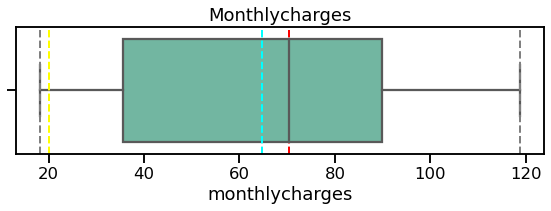

Minimum:18.25
Mean:64.76
Median:70.35
Mode:20.05
Maximum:118.75



In [16]:

fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (8,3))
min_val = data['monthlycharges'].min()
max_val = data['monthlycharges'].max()
mean_val = data['monthlycharges'].mean()
med_val = data['monthlycharges'].median()
mod_val = data['monthlycharges'].mode()[0]
sns.boxplot(x = 'monthlycharges', data= data, orient="h", palette="Set2")
axes.axvline(x= min_val, color = 'gray', linestyle='dashed', linewidth = 2)
axes.axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
axes.axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
axes.axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
axes.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)
plt.tight_layout()
plt.title(data['monthlycharges'].name.title())
plt.show()
print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

We can see that are most common charge is 20.05 but are Median and Mean are in the 65-70 Range we can also see that our Maximun values is 118

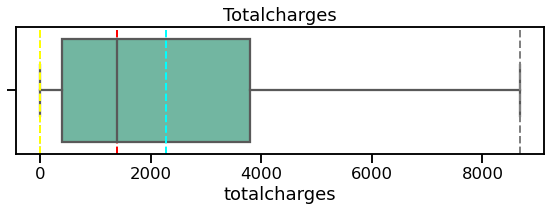

Minimum:0.00
Mean:2279.73
Median:1394.55
Mode:0.00
Maximum:8684.80



In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (8,3))
min_val = data['totalcharges'].min()
max_val = data['totalcharges'].max()
mean_val = data['totalcharges'].mean()
med_val = data['totalcharges'].median()
mod_val = data['totalcharges'].mode()[0]
sns.boxplot(x = 'totalcharges', data= data, orient="h", palette="Set2")
axes.axvline(x= min_val, color = 'gray', linestyle='dashed', linewidth = 2)
axes.axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
axes.axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
axes.axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
axes.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)
plt.tight_layout()
plt.title(data['totalcharges'].name.title())
plt.show()
print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

All numeric column seem to be normally distrubted after reviewing them.

# Statistical Analysis

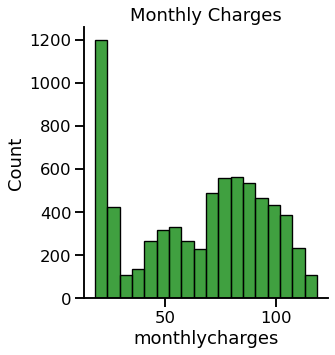

In [58]:
#Printing the distribution of our Monthly Charges column 
sns.displot(data['monthlycharges'], kind = 'hist' , legend= True, color = 'g')
plt.title('Monthly Charges')
plt.show()

#### Let's create a sampling distribution from this population (sample size=30, number of samples = 500)

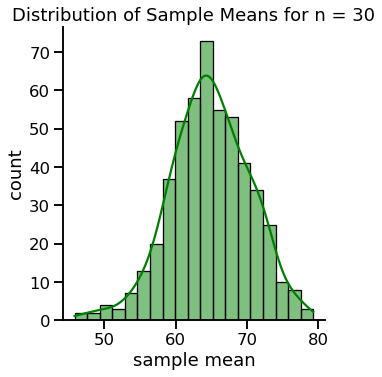

In [59]:
# set the seed for reproducibility
np.random.seed(1)
# set the sample size to 10
n = 30
# list to store sample means
sample_means = []
# iterate the loop to draw multiple samples
for j in range(500):
    # draw a sample of size n
    sample = np.random.choice(data['monthlycharges'], size=n)
    # calculate the sample mean
    sample_mean = np.mean(sample)
    # append the sample mean to the sample_means list
    sample_means.append(sample_mean)
# plot the histogram of sample means
sns.displot(sample_means, kde=True, color='g')
plt.title("Distribution of Sample Means for n = " + str(n))
plt.xlabel("sample mean")
plt.ylabel("count")
plt.show()

In [60]:
mean, std, = np.mean(sample_means), np.std(sample_means)
print(f'Sample mean: {mean}\nSample std: {std}')
#set the values of sample means 
n = 30
# construct the confidence interval
print(np.round(st.norm.interval(0.95, loc=mean, scale=std/ np.sqrt(n)), 2))

Sample mean: 64.83555666666668
Sample std: 5.544319764518757
[62.85 66.82]


Here we set up a sample mean and sample std from our monthly charges column and setup our confidence intervals at 95%
From this we can conclude that 95% of our monthly charges lie within [62.85 66.82] dollars

In [61]:
#What is the probability that the monthly are more than 70?
round(1- st.norm.cdf(70,loc = mean,scale =std),5)

0.1758

In [62]:
#What is the probability that the monthly lies betweem 65 - 40?
st.norm.cdf(65,loc = mean,scale =std) - st.norm.cdf(40,loc = mean,scale =std) 

0.5118270661102418

In [63]:
#What is the amount below which lies bottom 50% of monthly Charges?
round(st.norm.ppf(0.50,loc=mean,scale=std), 4)

64.8356

In [64]:
# What is the amount above which lies top 15% of monthly charges?
st.norm.ppf(0.85,loc=mean,scale=std)

70.58187479264426

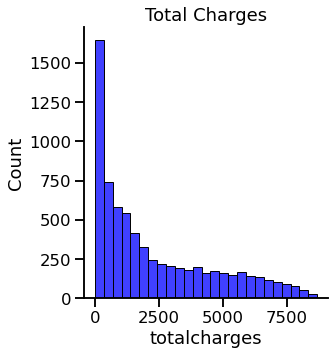

In [65]:
#Printing the distriubtion of our total charges 
sns.displot(data['totalcharges'], kind = 'hist' , legend= True, color = 'b')
plt.title('Total Charges')
plt.show()

#### Let's create a sampling distribution from this population (sample size=30, number of samples = 500)

 

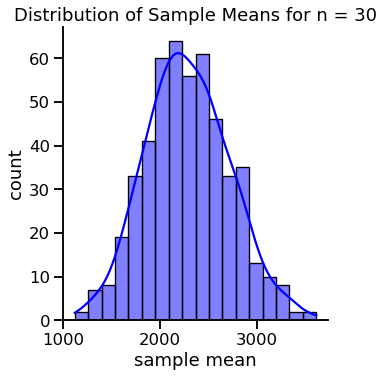

In [66]:
# set the seed for reproducibility
np.random.seed(1)
# set the sample size to 20
n = 30
# list to store sample means
sample_means = []
# iterate the loop to draw multiple samples
for j in range(500):
    # draw a sample of size n
    sample = np.random.choice(data['totalcharges'], size=n)
    # calculate the sample mean
    sample_mean = np.mean(sample)
    # append the sample mean to the sample_means list
    sample_means.append(sample_mean)
# plot the histogram of sample means
sns.displot(sample_means, kde=True, color = 'b')
plt.title("Distribution of Sample Means for n = " + str(n))
plt.xlabel("sample mean")
plt.ylabel("count")
plt.show()

In [67]:
mean, std, = np.mean(sample_means), np.std(sample_means)
print(f'Sample mean: {mean}\nSample std: {std}')
#set the values of sample means 
n = 30
# construct the confidence interval
print(np.round(st.norm.interval(0.95, loc=mean, scale=std/ np.sqrt(n)), 2))


Sample mean: 2285.3000333333334
Sample std: 430.61723369614583
[2131.21 2439.39]


Here we set up a sample mean and sample std from our total charges column and setup our confidence intervals at 95%
From this we can conclude that 95% of our total charges lie within  [2131.21 2439.39]

In [68]:
#What is the amount below which lies bottom 25% of total charges?
round(st.norm.ppf(0.25,loc=mean,scale=std), 4)

1994.8531

In [69]:
#What is the probability that the totalcharges are less than 3000?
st.norm.cdf(3000,loc = mean,scale =std)

0.9515136522214407

In [70]:
#99% percent of total charges are above ? 
round(st.norm.ppf(0.01,loc=mean,scale=std), 4)

1283.5345

In [92]:
#Making a copy of our orginal dataset for plotting purposes 
df = data.copy()
#lets change all the dates to yes signifying that they left the company 
df.loc[df['enddate'] != 'No','enddate'] = '1'
#Changing the no to zero signifying that they are still with the company 
df.loc[df['enddate'] == 'No','enddate'] = '0'

In [93]:
def inpendence(col,col2):
    alpha = 0.05 
    cross_tab = pd.crosstab(df[col],df[col2])
    display(cross_tab)
    chi, pvalue,dof,expected = chi2_contingency(cross_tab)
    print(f'H0: {df[col].name} is independent of {df[col2].name}' )
    print(f'HA: {df[col].name} depends on  {df[col2].name}' )
    print('p-value: ',pvalue)
    if pvalue < alpha:
        print('We reject the null hypothesis')
    else:
        print("We can't reject the null hypothesis")    

In [94]:
inpendence('enddate','paymentmethod')

paymentmethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
enddate,,,,
0,1286,1290,1294,1304
1,258,232,1071,308


H0: enddate is independent of paymentmethod
HA: enddate depends on  paymentmethod
p-value:  3.6823546520097993e-140
We reject the null hypothesis


# H0: Left Total Charges are the same as Stayed Total Charges 
# HA: They are different 

In [97]:
left = df[df.enddate == '1']
stayed = df[df.enddate == '0']

In [98]:
#import the required functions
from scipy.stats import ttest_ind

# find the p-value
test_stat, p_value = ttest_ind(left['totalcharges'], stayed['totalcharges'], equal_var = False, alternative = 'two-sided')
print('The p-value is ' + str(p_value))

The p-value is 5.902580609072126e-75


We can conclude that they are different since our p value is very small 

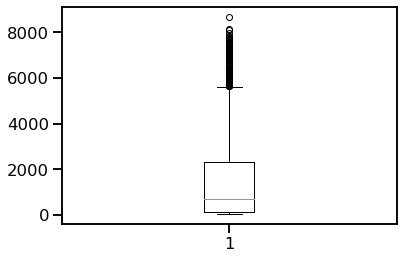

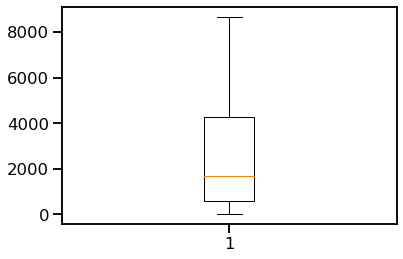

In [100]:
plt.figure()
plt.boxplot(left['totalcharges'])
plt.figure()
plt.boxplot(stayed.totalcharges)
plt.show()

# Target Analysis

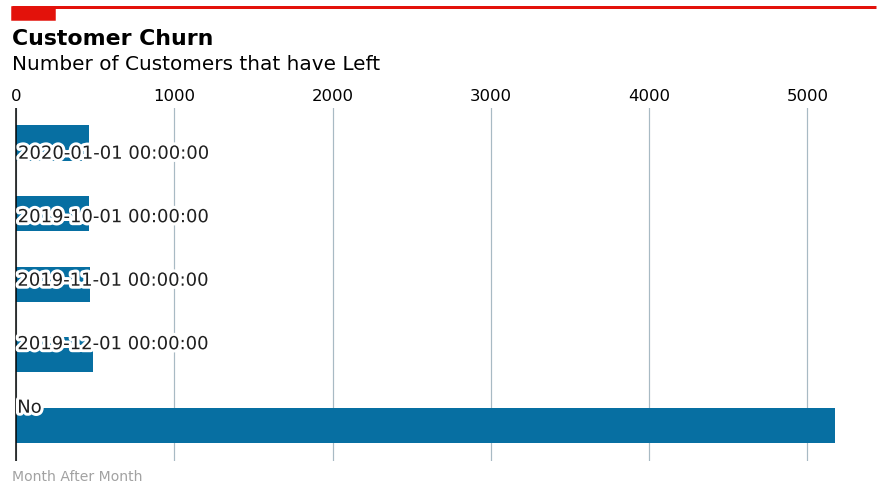

In [101]:
counts = [6, 7, 7, 9, 11]
names = list(data.enddate.unique())

# The positions for the bars
# This allows us to determine exactly where each bar is located
y = [i *.9 for i in range(len(names))]

BLUE = "#076fa2"
RED = "#E3120B"
BLACK = "#202020"
GREY = "#a2a2a2"
fig = plt.figure(figsize= (12,7))
ax = data.enddate.value_counts().sort_values(ascending = False).plot.barh( align="edge", color=BLUE)
ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)
# Set whether axis ticks and gridlines are above or below most artists.
ax.set_axisbelow(True)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_lw(1.5)
ax.spines["left"].set_capstyle("butt")
ax.yaxis.set_visible(False)


PAD = .5
for name, count, y_pos in zip(names, counts, y):
    x = 0
    color = "white"
    path_effects = None
    if count < 30:
        x = count
        color = BLACK   
        path_effects=[withStroke(linewidth=6, foreground="white")]
    
    ax.text(
        x + PAD, y_pos + 1 / 2, name, 
        color=color, fontfamily="Econ Sans Cnd", fontsize=18, va="center",
        path_effects=path_effects
    )
fig.subplots_adjust(left=0.005, right=1, top=0.8, bottom=0.1)
# Add title
fig.text(
    0, 0.925, "Customer Churn", 
    fontsize=22, fontweight="bold", fontfamily="Econ Sans Cnd")
# Add caption
source = "Month After Month"
fig.text(
    0, 0.06, source, color=GREY, 
    fontsize=14, fontfamily="Econ Sans Cnd"
)
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color=RED, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color=RED))
fig.text(
    0, 0.875, "Number of Customers that have Left", 
    fontsize=20, fontfamily="Econ Sans Cnd"
)
fig.set_facecolor("white")
plt.show()




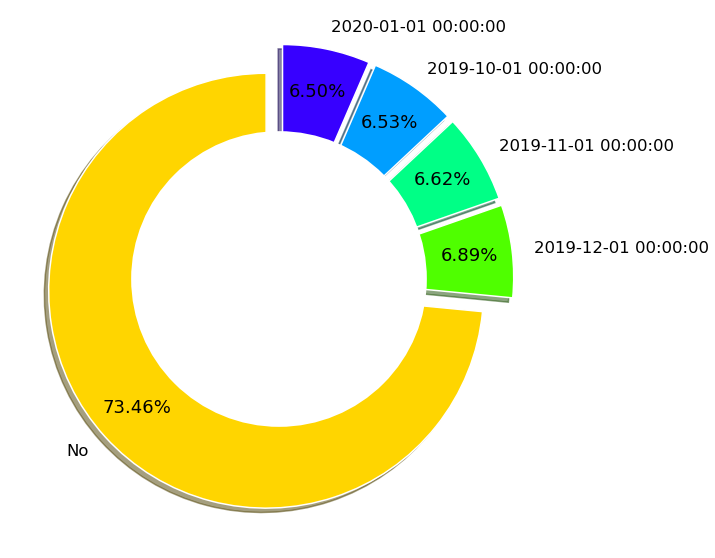

In [102]:
# A pie Chart 

colors = sns.color_palette("hsv")[0:5]
labels = data.enddate.unique()
plt.figure(figsize= (10,10))
plt.pie(data.enddate.value_counts(),
        labels = labels, 
        colors=colors, 
        autopct= '%.2f%%', 
        shadow= True, 
        explode = [.08, .08, .08, .08, .08],
        startangle=90,
        wedgeprops={'edgecolor': 'white'},
        pctdistance=0.8
        )
centre_circle = plt.Circle((0,0),0.68,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

We can see that we still have 5174 customers that have not churn yet roughly 73%, And we can see that 7% of people have left the business month after month 

In [103]:
print(df.enddate.value_counts(normalize=True))
print(df.enddate.value_counts())

0    0.73463
1    0.26537
Name: enddate, dtype: float64
0    5174
1    1869
Name: enddate, dtype: int64


We can see that we have a total 73% returning customers and a total 26% of customers that have left 

Lets see how our target variable is correlated with our columns 

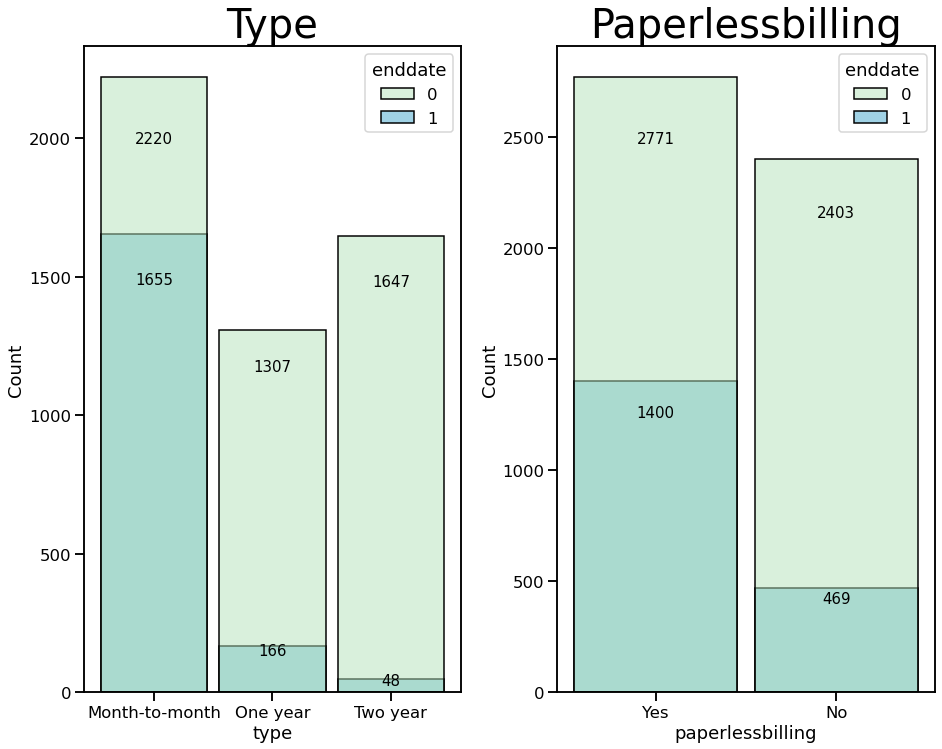

In [104]:
fig = plt.figure(figsize = (20,20))
for i ,j in enumerate(df.drop(['begindate','customerid','totalcharges','monthlycharges'], axis = 1).iloc[:,1:3]):
    ax = fig.add_subplot(2,3,i+1)
    ax = sns.histplot(data =df ,x = j ,hue= 'enddate', cbar= True, shrink=.9, palette='GnBu' , alpha = 0.5)
    plt.title(j.title(), fontsize = 40)
    plt.tight_layout()
    for i in ax.patches:
        ax.text(i.get_x()+i.get_width()/2,i.get_height()*0.90,i.get_height(),color='k',
           ha='center',va='center',c='black',fontsize=15)

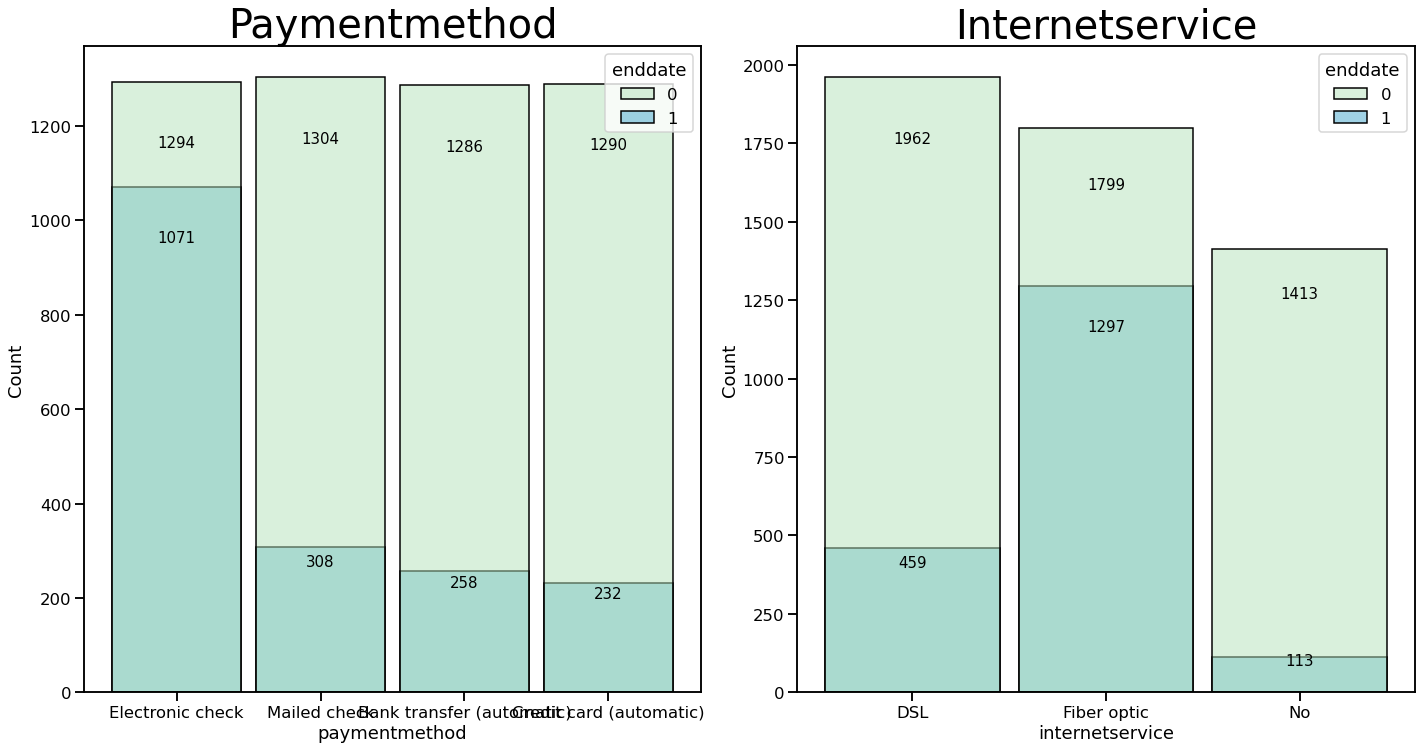

In [105]:
fig = plt.figure(figsize = (30,20))
for i ,j in enumerate(df.drop(['begindate','customerid','totalcharges','monthlycharges'], axis = 1).iloc[:,3:5]):
    ax = fig.add_subplot(2,3,i+1)
    axes = sns.histplot(data =df ,x = j ,hue= 'enddate', cbar= True,shrink=.9 , palette='GnBu')
    plt.title(j.title(), fontsize = 40)
    #axes.set_yticklabels(axes.get_yticks(), weight='bold')
    #axes.set_xticklabels(axes.get_xticks(), rotation=0, weight='bold', size=25)
    plt.tight_layout()
    for i in ax.patches:
        ax.text(i.get_x()+i.get_width()/2,i.get_height()*0.90,i.get_height(),color='k',
           ha='center',va='center',c='black',fontsize=15)


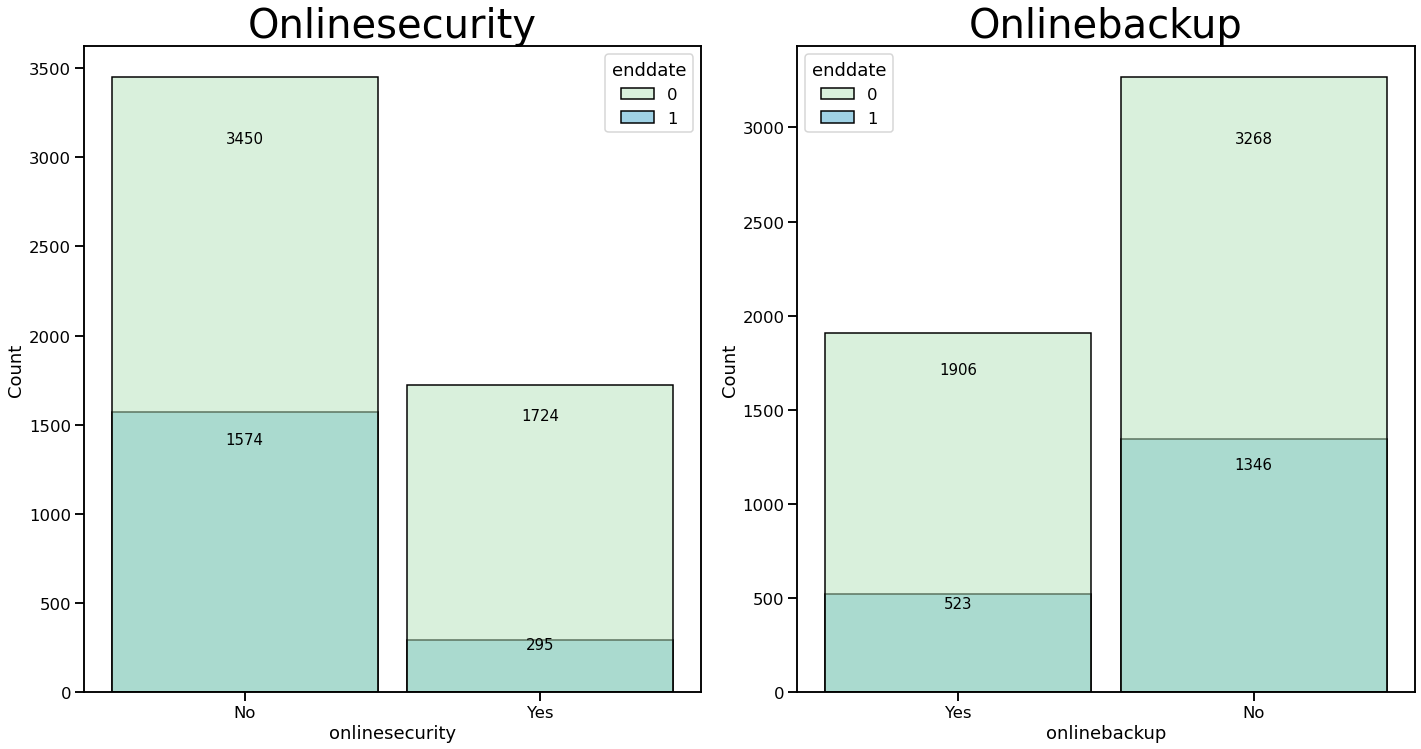

In [106]:
fig = plt.figure(figsize = (30,20))
for i ,j in enumerate(df.drop(['begindate','customerid','totalcharges','monthlycharges'], axis = 1).iloc[:,5:7]):
    ax = fig.add_subplot(2,3,i+1)
    axes = sns.histplot(data =df ,x = j ,hue= 'enddate', cbar= True,shrink=.9  ,palette='GnBu')
    plt.title(j.title(), fontsize = 40)
    #axes.set_yticklabels(axes.get_yticks(), weight='bold')
    #axes.set_xticklabels(axes.get_xticks(), rotation=10, weight='bold', size=10)
    plt.tight_layout()
    for i in ax.patches:
        ax.text(i.get_x()+i.get_width()/2,i.get_height()*0.90,i.get_height(),color='k',
           ha='center',va='center',c='black',fontsize=15)

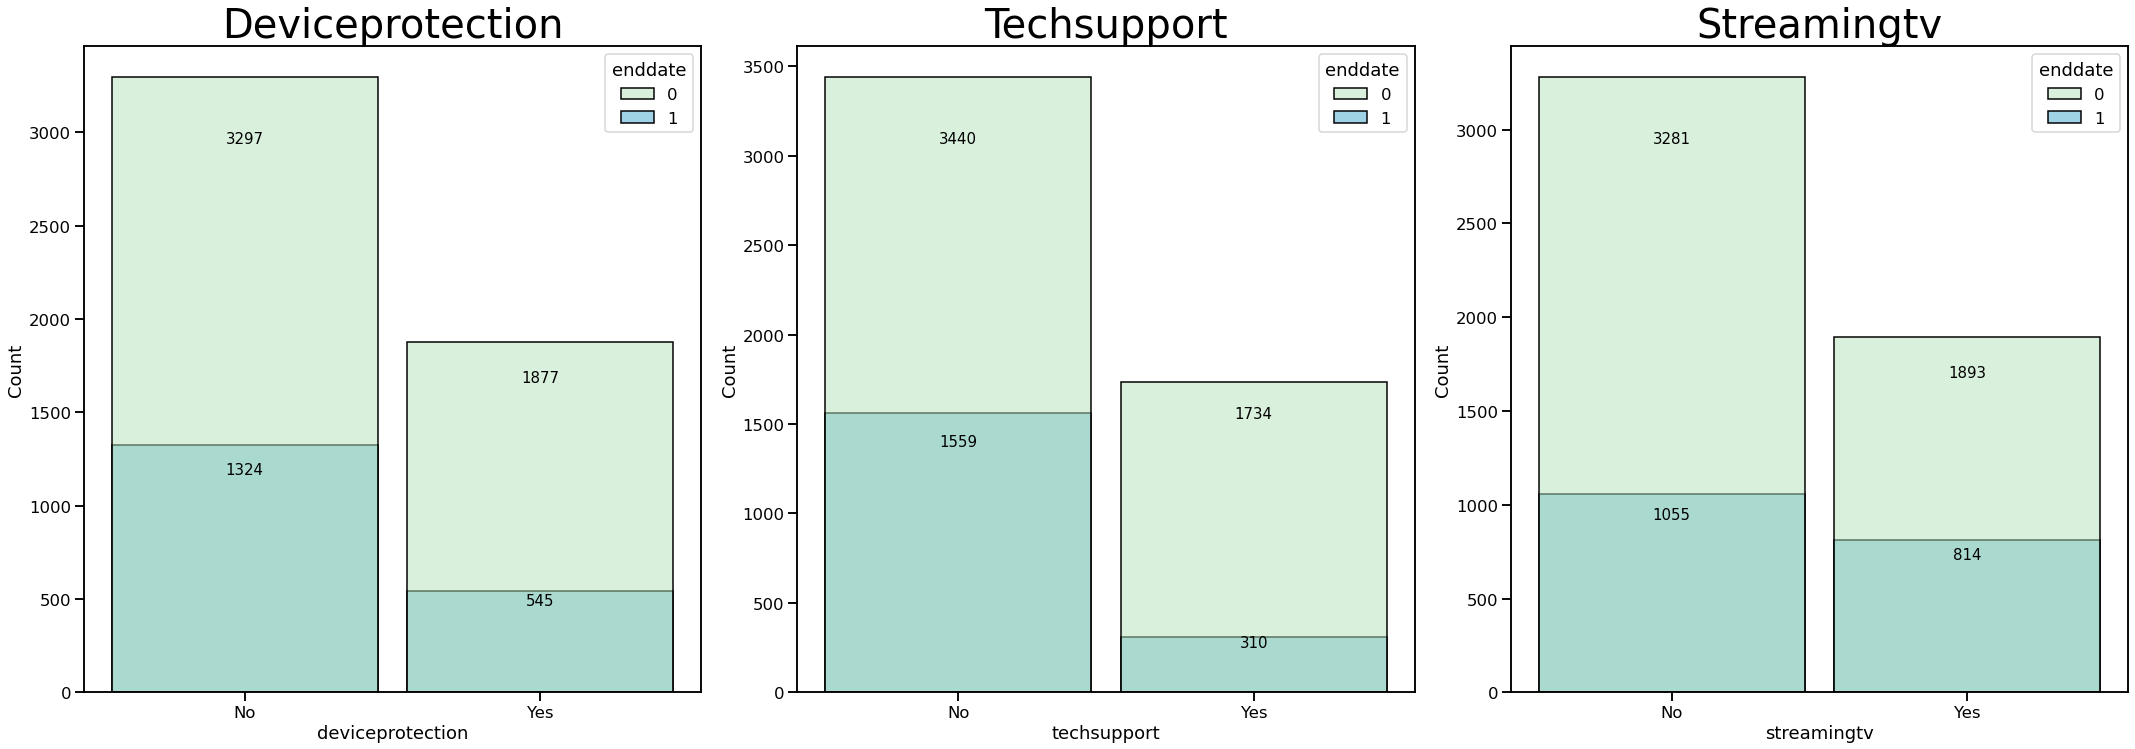

In [107]:
fig = plt.figure(figsize = (30,20))
for i ,j in enumerate(df.drop(['begindate','customerid','totalcharges','monthlycharges'], axis = 1).iloc[:,7:10]):
    ax = fig.add_subplot(2,3,i+1)
    axes = sns.histplot(data =df ,x = j ,hue= 'enddate', cbar= True,shrink=.9  ,palette='GnBu')
    plt.title(j.title(), fontsize = 40)
    #axes.set_yticklabels(axes.get_yticks(), weight='bold')
    #axes.set_xticklabels(axes.get_xticks(), rotation=10, weight='bold', size=10)
    plt.tight_layout()
    for i in ax.patches:
        ax.text(i.get_x()+i.get_width()/2,i.get_height()*0.90,i.get_height(),color='k',
           ha='center',va='center',c='black',fontsize=15)

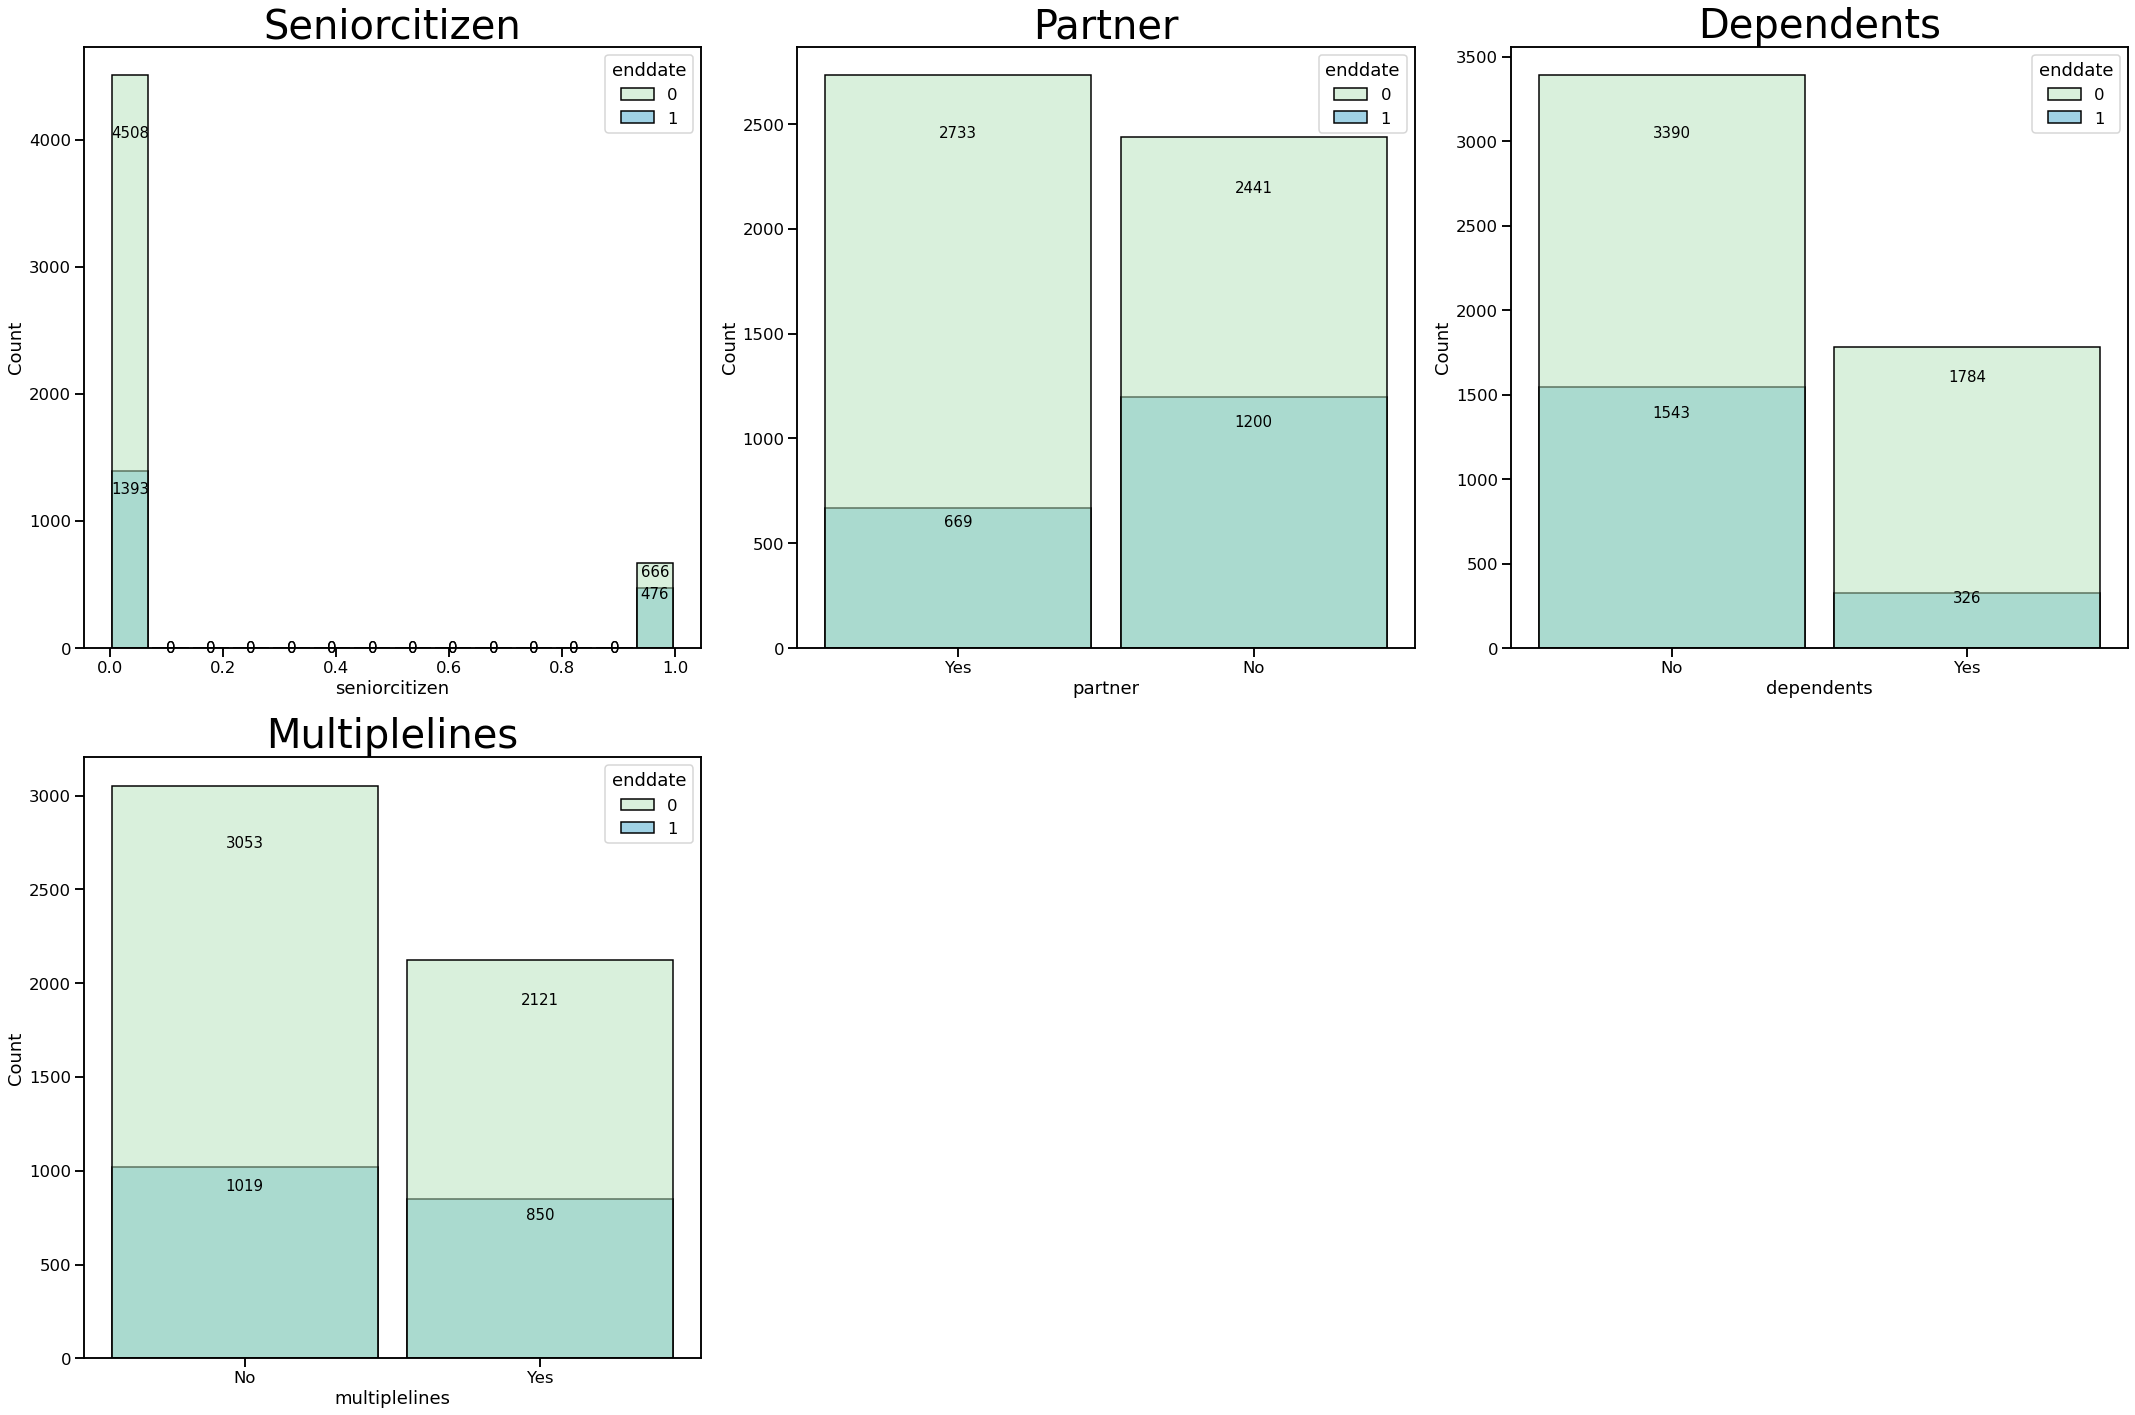

In [108]:
fig = plt.figure(figsize = (30,20))
for i ,j in enumerate(df.drop(['begindate','customerid','totalcharges','monthlycharges'], axis = 1).iloc[:,12:19]):
    ax = fig.add_subplot(2,3,i+1)
    axes = sns.histplot(data =df ,x = j ,hue= 'enddate', cbar= True,shrink=.9  ,palette='GnBu')
    plt.title(j.title(), fontsize = 40)
    #axes.set_yticklabels(axes.get_yticks(), weight='bold')
    #axes.set_xticklabels(axes.get_xticks(), rotation=10, weight='bold', size=10)
    plt.tight_layout()
    for i in ax.patches:
        ax.text(i.get_x()+i.get_width()/2,i.get_height()*0.90,i.get_height(),color='k',
           ha='center',va='center',c='black',fontsize=15)

After reviewing each column we can see that that our highest feature where customers have left is in the type. People are paying month to month have been leaving most often. We can also that in our payment method customers are leaving as well 
mostly in our Electronic check column. On average we can see that most customers have left in all columns that do not have any amenities like (Device Protection Tech Support Streaming TV etc ). We dont have enough information to see if customer are choosing the the month to month plan because it cheaper and doesnt come with any extra features So the customer is just testing the service and choosing to leave after. We will need more data to make any concrete conclusion. 

In [109]:
# Extracting year, month, day and day of week from our begin date column 
df.index = df.begindate
def make_features(data):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    
    

In [110]:
#calling the function
make_features(df)

In [111]:
# We can see all our columns after tje extracting 
df.drop(['begindate'], axis=1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7043 entries, 2020-01-01 to 2014-08-01
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   enddate           7043 non-null   object 
 2   type              7043 non-null   object 
 3   paperlessbilling  7043 non-null   object 
 4   paymentmethod     7043 non-null   object 
 5   monthlycharges    7043 non-null   float64
 6   totalcharges      7043 non-null   float64
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  gender            7043 non-null   object 
 15  seniorcitizen     7043 non-null   int64  
 16  partner           7043 n

In [112]:
# We can see that are enddate column is a object lets change that to int since its our target variable 
df.enddate = df.enddate.astype('int64')

# Split Data

In [113]:
### Split the Data 
X = df.drop(['enddate','customerid'], axis =  1 )
y = (df['enddate'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=12345)

In [114]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2,stratify = y_train, random_state=12345)

In [115]:
#function to print the variable name 
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
#looping over the spilt data to get spilt rows and columns
for part in [X_train, y_train, X_test, y_test, X_valid, y_valid]:
    print(namestr(part, globals())[0], part.shape)

X_train (4507, 21)
y_train (4507,)
X_test (1409, 21)
y_test (1409,)
X_valid (1127, 21)
y_valid (1127,)


# Model Creation

In [116]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4507 entries, 2016-09-01 to 2019-12-01
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              4507 non-null   object 
 1   paperlessbilling  4507 non-null   object 
 2   paymentmethod     4507 non-null   object 
 3   monthlycharges    4507 non-null   float64
 4   totalcharges      4507 non-null   float64
 5   internetservice   4507 non-null   object 
 6   onlinesecurity    4507 non-null   object 
 7   onlinebackup      4507 non-null   object 
 8   deviceprotection  4507 non-null   object 
 9   techsupport       4507 non-null   object 
 10  streamingtv       4507 non-null   object 
 11  streamingmovies   4507 non-null   object 
 12  gender            4507 non-null   object 
 13  seniorcitizen     4507 non-null   int64  
 14  partner           4507 non-null   object 
 15  dependents        4507 non-null   object 
 16  multiplelines     4507 n

In [117]:
numeric_features = [3,4,17,18,20]
categorical_features = [0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,19,]

def model_creation(model,X_train, X_valid, y_train, y_valid , numeric_features,categorical_features):

    # Define preprocessing for numeric columns (scale them)
    numeric_features = numeric_features
    numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

    # Define preprocessing for categorical features (encode them)
    categorical_features = categorical_features
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('Classifier',model)])
    clf.fit(X_train,(y_train))
    y_pred = clf.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
    disp.plot()
    print(classification_report(y_test, y_pred))

# Performance metric
- Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be misleading. Metrics that can provide better insight include:

- Confusion Matrix: a talbe showing correct predictions and types of incorrect predictions.
- Precision: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier's exactness. Low precision indicates a high number of false positives.
- Recall: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier's completeness. Low recall indicates a high number of false negatives.
- F1: Score: the weighted average of precision and recall.

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1035
           1       0.85      0.66      0.74       374

    accuracy                           0.88      1409
   macro avg       0.87      0.81      0.83      1409
weighted avg       0.88      0.88      0.87      1409



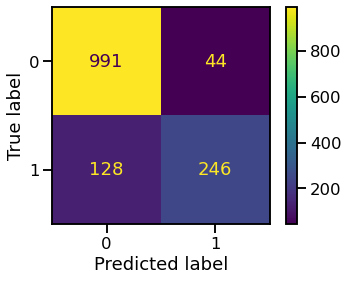

In [118]:
 model_creation(XGBClassifier(), X_train, X_valid, y_train, y_valid,numeric_features , categorical_features)

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1035
           1       0.75      0.55      0.63       374

    accuracy                           0.83      1409
   macro avg       0.80      0.74      0.76      1409
weighted avg       0.82      0.83      0.82      1409



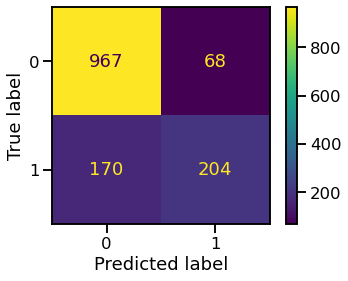

In [119]:
model_creation(RandomForestClassifier(), X_train, X_valid, y_train, y_valid,numeric_features , categorical_features)

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1035
           1       0.86      0.66      0.74       374

    accuracy                           0.88      1409
   macro avg       0.87      0.81      0.83      1409
weighted avg       0.88      0.88      0.87      1409



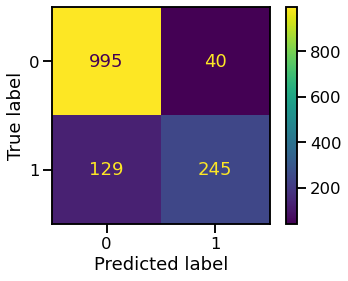

In [120]:
model_creation(LGBMClassifier(), X_train, X_valid, y_train, y_valid,numeric_features , categorical_features)

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1035
           1       0.71      0.52      0.60       374

    accuracy                           0.82      1409
   macro avg       0.78      0.72      0.74      1409
weighted avg       0.81      0.82      0.81      1409



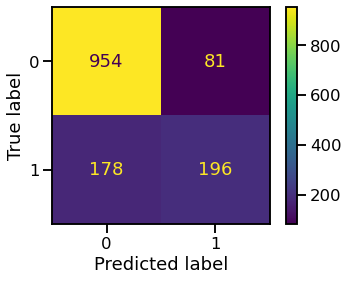

In [121]:
model_creation(SVC(),X_train, X_valid, y_train, y_valid,numeric_features , categorical_features)

In [122]:
# Define preprocessing for numeric columns (scale them)
numeric_features = numeric_features
numeric_transformer = Pipeline(steps=[
('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = categorical_features
categorical_transformer = Pipeline(steps=[
('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('Classifier',XGBClassifier())])




In [123]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

          train  test
Accuracy    1.0  0.89
F1          1.0  0.77
APS         1.0  0.88
ROC AUC     1.0  0.93


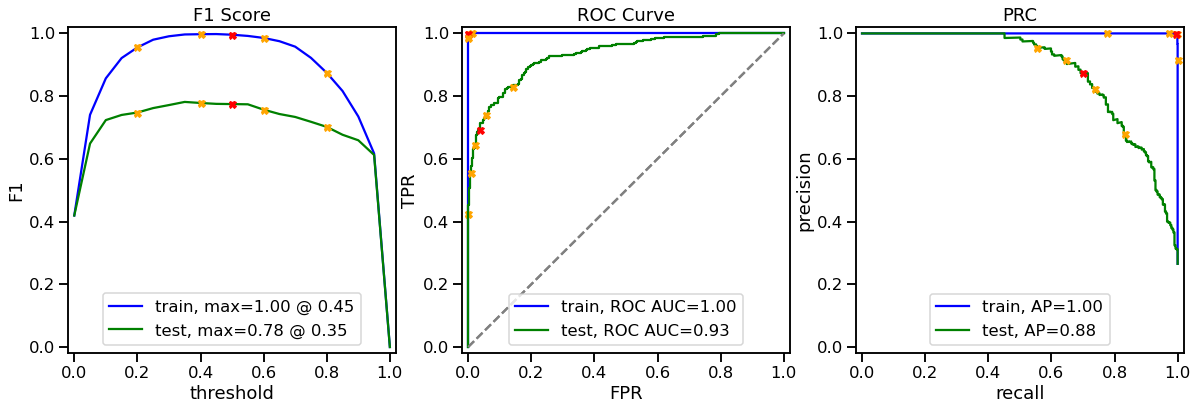

In [124]:
 evaluate_model(clf.fit(X_train,y_train), train_features = X_train, train_target = y_train, test_features = X_valid, test_target= y_valid)

From Our Classification report and our Confusiom Matrix We can see XGB Classifer did the best out of all four it had the most True postives and True Negative from the four Classifers and When comparing all models we can see that the F1 score was much better using the XGB Classifer

# Train Data using TensorFlow

In [125]:
#Create a model 

model = tf.keras.models.Sequential([
    #tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])


model.compile(loss = tf.keras.losses.binary_crossentropy,
             optimizer = 'Adam',
             metrics= ['accuracy'])

In [126]:
df.drop(['customerid'], axis = 1)
data_ohe = pd.get_dummies(df)

In [127]:
### Split the Data 
X = data_ohe.drop(['enddate'], axis =  1 )
y = (data_ohe['enddate'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=12345)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2,stratify = y_train, random_state=12345)

In [128]:
cols = list(X_train.columns)
scaler = StandardScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])
X_valid[cols] = scaler.transform(X_valid[cols])

In [129]:
history = model.fit(X_train, y_train, epochs =10, validation_data=(X_valid,y_valid))

Epoch 1/10
141/141 [==============================] - 2s 7ms/step - loss: 1.5696 - accuracy: 0.3477 - val_loss: 2.8960 - val_accuracy: 0.7347
Epoch 2/10
141/141 [==============================] - 1s 5ms/step - loss: 0.7242 - accuracy: 0.6958 - val_loss: 2.5288 - val_accuracy: 0.7347
Epoch 3/10
141/141 [==============================] - 1s 4ms/step - loss: 0.3503 - accuracy: 0.8620 - val_loss: 2.0601 - val_accuracy: 0.7347
Epoch 4/10
141/141 [==============================] - 1s 4ms/step - loss: 0.1827 - accuracy: 0.9445 - val_loss: 1.9347 - val_accuracy: 0.7347
Epoch 5/10
141/141 [==============================] - 1s 4ms/step - loss: 0.0991 - accuracy: 0.9738 - val_loss: 1.8356 - val_accuracy: 0.7347
Epoch 6/10
141/141 [==============================] - 1s 5ms/step - loss: 0.0597 - accuracy: 0.9849 - val_loss: 1.8071 - val_accuracy: 0.7347
Epoch 7/10
141/141 [==============================] - 1s 4ms/step - loss: 0.0404 - accuracy: 0.9891 - val_loss: 1.8318 - val_accuracy: 0.7347
Epoch 

In [130]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  #plot loss
  plt.plot(epochs, loss,label = 'training_loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training_accuracy')
  plt.plot(epochs, val_accuracy, label = 'val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

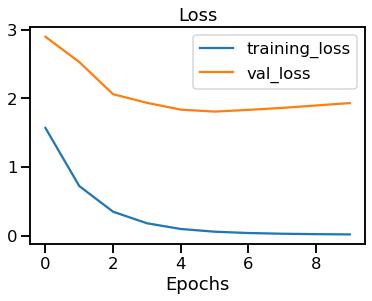

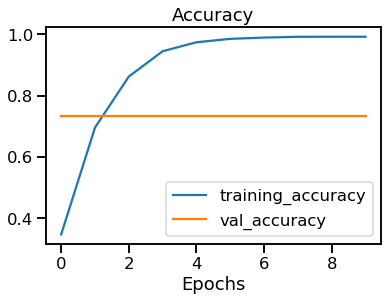

In [131]:
plot_loss_curves(history)

In [132]:
y_pred = model.predict(X_test)


45/45 [==============================] - 0s 3ms/step


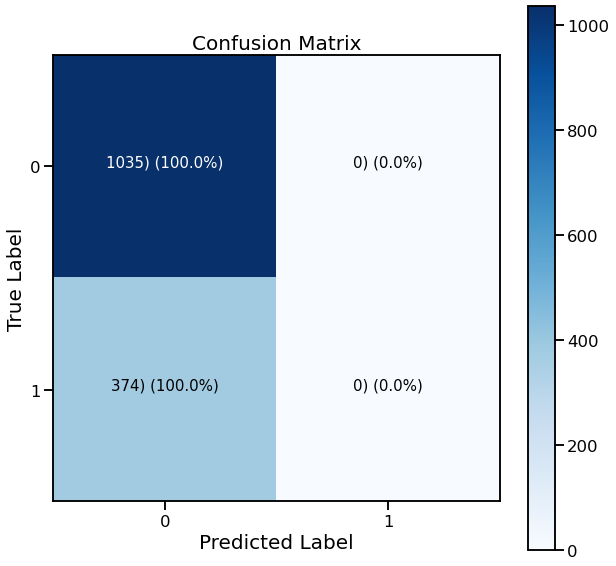

In [133]:
import itertools 
figsize = (10,10)
#create the confusion matrix
cm = confusion_matrix(y_test,tf.round(y_pred))
cm_norm = cm.astype('float')/cm.sum(axis = 1)[:,np.newaxis]
n_classes = cm.shape[0]



fig,ax = plt.subplots(figsize= figsize)
cax = ax.matshow(cm,cmap = plt.cm.Blues)
fig.colorbar(cax)

classes = False

if classes: 
    labels = classes
else:
    labels = np.arange(cm.shape[0])
#label the axes

ax.set(
    title= "Confusion Matrix",
    xlabel = 'Predicted Label',
    ylabel = 'True Label',
    xticks = np.arange(n_classes),
    yticks = np.arange(n_classes),
    xticklabels = labels,
    yticklabels = labels
)
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.title.set_size(20)
threshold = (cm.max() + cm.min())/2


for i , j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,f'{cm[i,j]}) ({cm_norm[i,j]*100:.1f}%)',
             horizontalalignment = 'center',
             color = 'white'if cm[i,j] > threshold else 'black',
             size = 15)

We can see from our accuracy score was much higher on the neural network We got a higher True postive then all our models but our False postive was greater as well which was double then all other classifers 

# Resampling
A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).



Despite the advantage of balancing classes, these techniques also have their weaknesses . The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

In [134]:
# In our case we will use Oversampling because we have a small dataset
ros = RandomOverSampler(random_state=123)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

           0       0.87      0.75      0.80      1035
           1       0.50      0.70      0.58       374

    accuracy                           0.73      1409
   macro avg       0.68      0.72      0.69      1409
weighted avg       0.77      0.73      0.74      1409



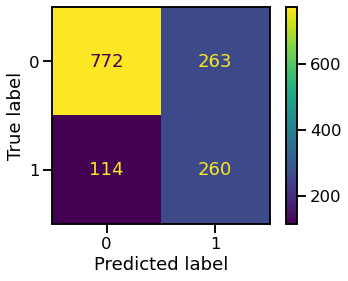

In [135]:
 model_creation(XGBClassifier(), X_ros, X_valid, y_ros, y_valid ,numeric_features , categorical_features)

          train  test
Accuracy   0.80  0.74
F1         0.81  0.59
APS        0.85  0.60
ROC AUC    0.87  0.81


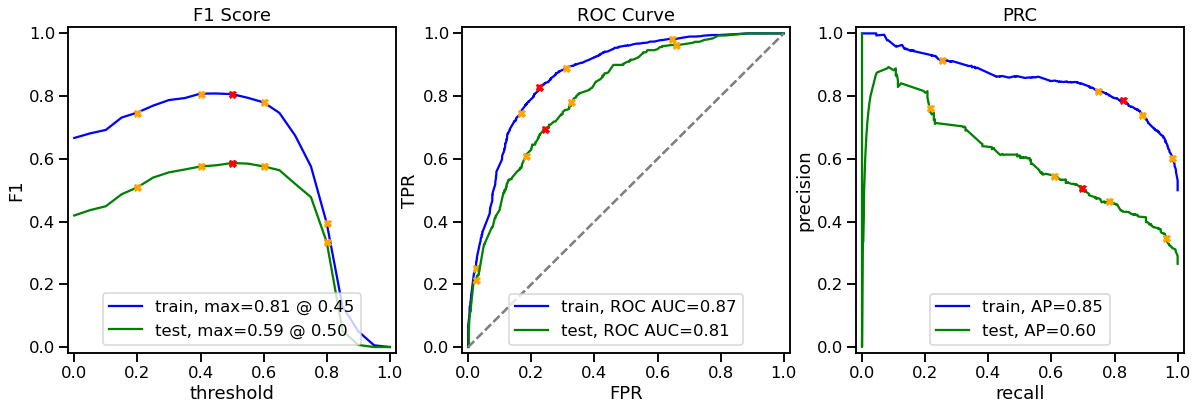

In [136]:
evaluate_model(clf.fit( X_ros,y_ros), train_features = X_ros, train_target =  y_ros, test_features = X_valid, test_target= y_valid)

Here we can conclude that our Data our best model didnt do as great on our oversampler data. Since our data was mild unbalanced we can conclude that our Oversample Was not needed

# Retrain Our Best Model
Let retrain our model using test set now 

In [137]:
XG = XGBClassifier(n_jobs =-1)
XG.fit(X_train,y_train)
y_pred =XG.predict(X_test)

Text(0.5, 1.0, 'Feature Importance')

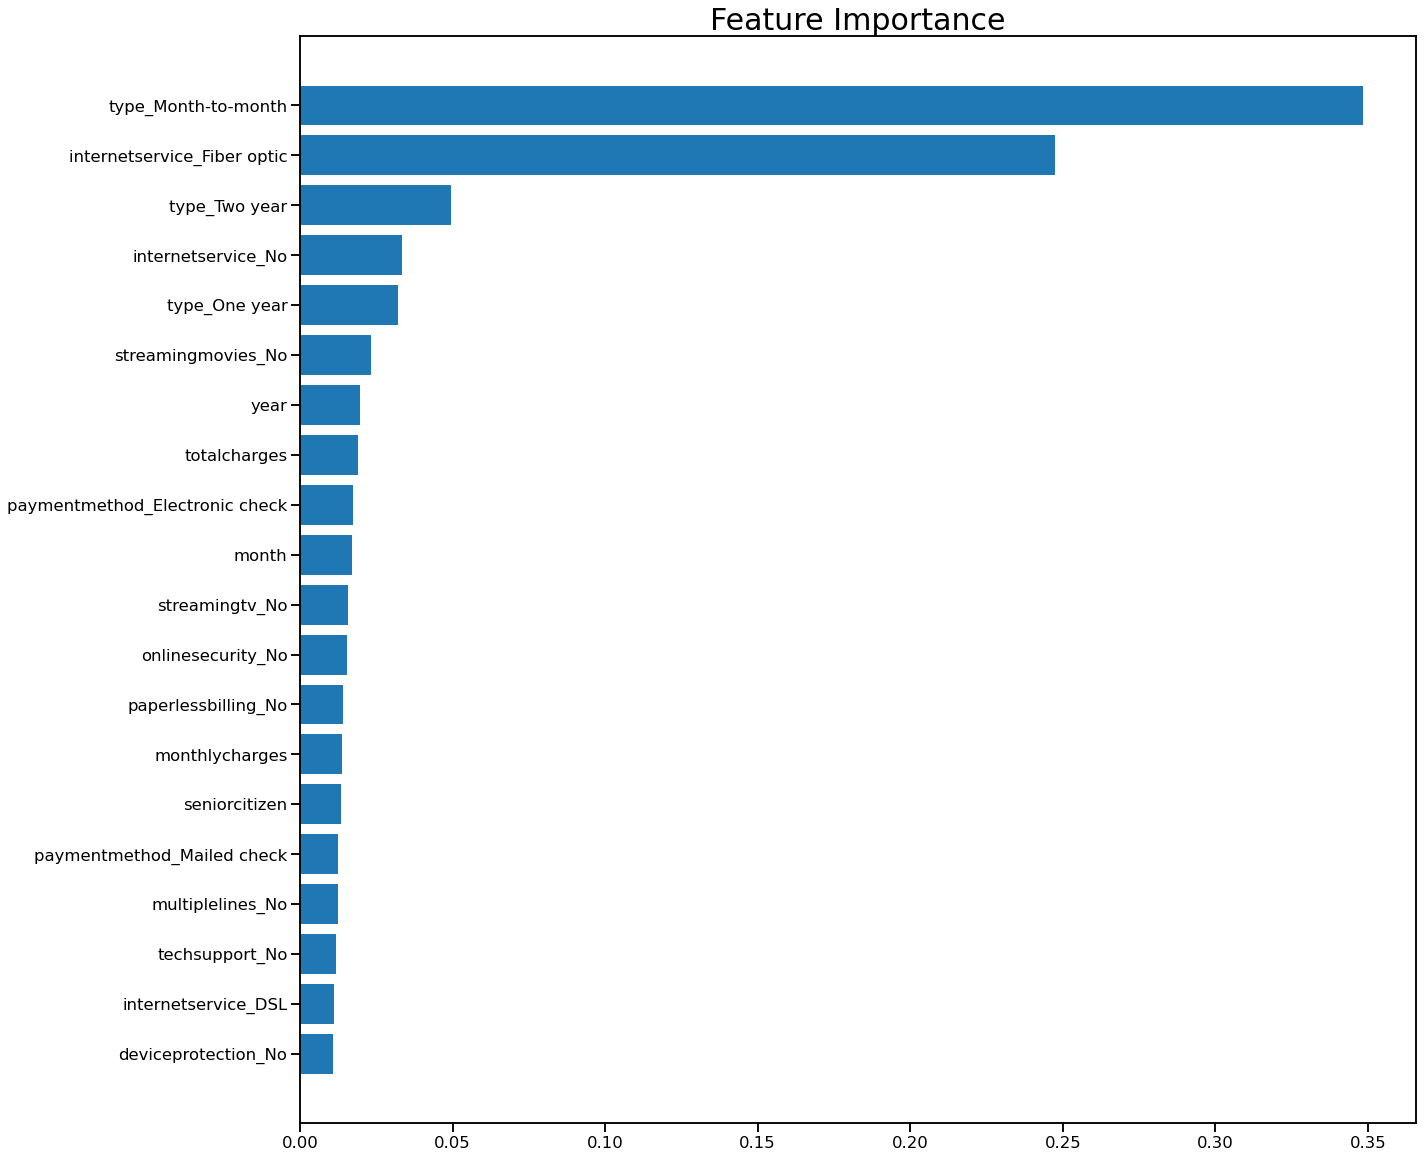

In [138]:
feature_importance = XG.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]
fig = plt.figure(figsize=(20,20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance', fontsize = 30)


In [139]:
probabilities_test = XG.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = round(roc_auc_score(y_test, probabilities_one_test) * 100, 2)
auc_roc

90.36

The AUC-ROC value is very high, it means that our model's predictions are correct in more than 90.36% of cases

In [140]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test) 

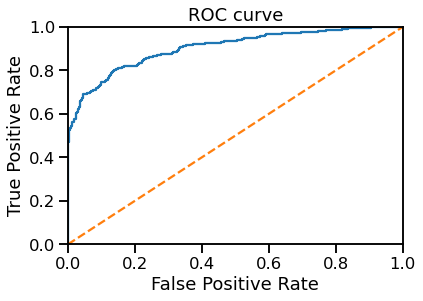

In [141]:
plt.figure()
plt.plot(fpr, tpr)
# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC curve')
plt.show()

# Conclusion 

In this analysis we imported all the data given:  
- Process the data : Checking Dtypes, Unique values, NAN.

- Statistical analysis: We took a sample distribution from both our monthly charges and total charges column since they were normally distrubted.  From this we can conclude that 95% of our monthly charges lie within 59.44 70.83 dollars and  we can conclude that 95% of our total charges lie within 2065.94 - 2509.83

- Exploratory data analysis- We can see that 73% of the customer remain with the company but 7% are leaving month after month. The majority of the customers left because they are on the type (month to month) which means they are paying monthly and are not on a contract. We can see that most  of the customers that are leaving dont have any extra features like in the online security, onlinebackup,device protection,and Techsupport etc. This can only mean that the user is only using the company sort of as test and leaving after. We will need more data to make any concrete conclusion.

- Model training :  Initialized 5  models and XGB Classifer was the best model out all of them . We can see from its confusion matrix and its accuracy score.It outperformed all of other classifers. After implmenting Features importance we can see that its most important feature was type(month to month) and internet service. We cant make any concrete conclusions but we can see that month to month type method is a big importance to our model. 
